---
# Gradient Descent Implementation
The start of every machine learning project begins the same way: 
- Data Inspection
- Data Visualization
- Data Regularization
- Model implementation

Our [data](https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set) is a set of real estate valuates from New Taipei City,Taiwan. We will first load a dataframe and inspect the data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

data_df = pd.read_csv('Real estate.csv')

print("Shape is: ", data_df.shape)
data_df[:10]


Shape is:  (414, 8)


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
5,6,2012.667,7.1,2175.03000,3,24.96305,121.51254,32.1
6,7,2012.667,34.5,623.47310,7,24.97933,121.53642,40.3
7,8,2013.417,20.3,287.60250,6,24.98042,121.54228,46.7
8,9,2013.500,31.7,5512.03800,1,24.95095,121.48458,18.8
9,10,2013.417,17.9,1783.18000,3,24.96731,121.51486,22.1


---
## Visualization

The dataset has 6 features and 1 output. We cannot visualize 6-dimensional data, however we can inspect each feature against the output to identify any important correlations between the features. 

Number of columns: 8


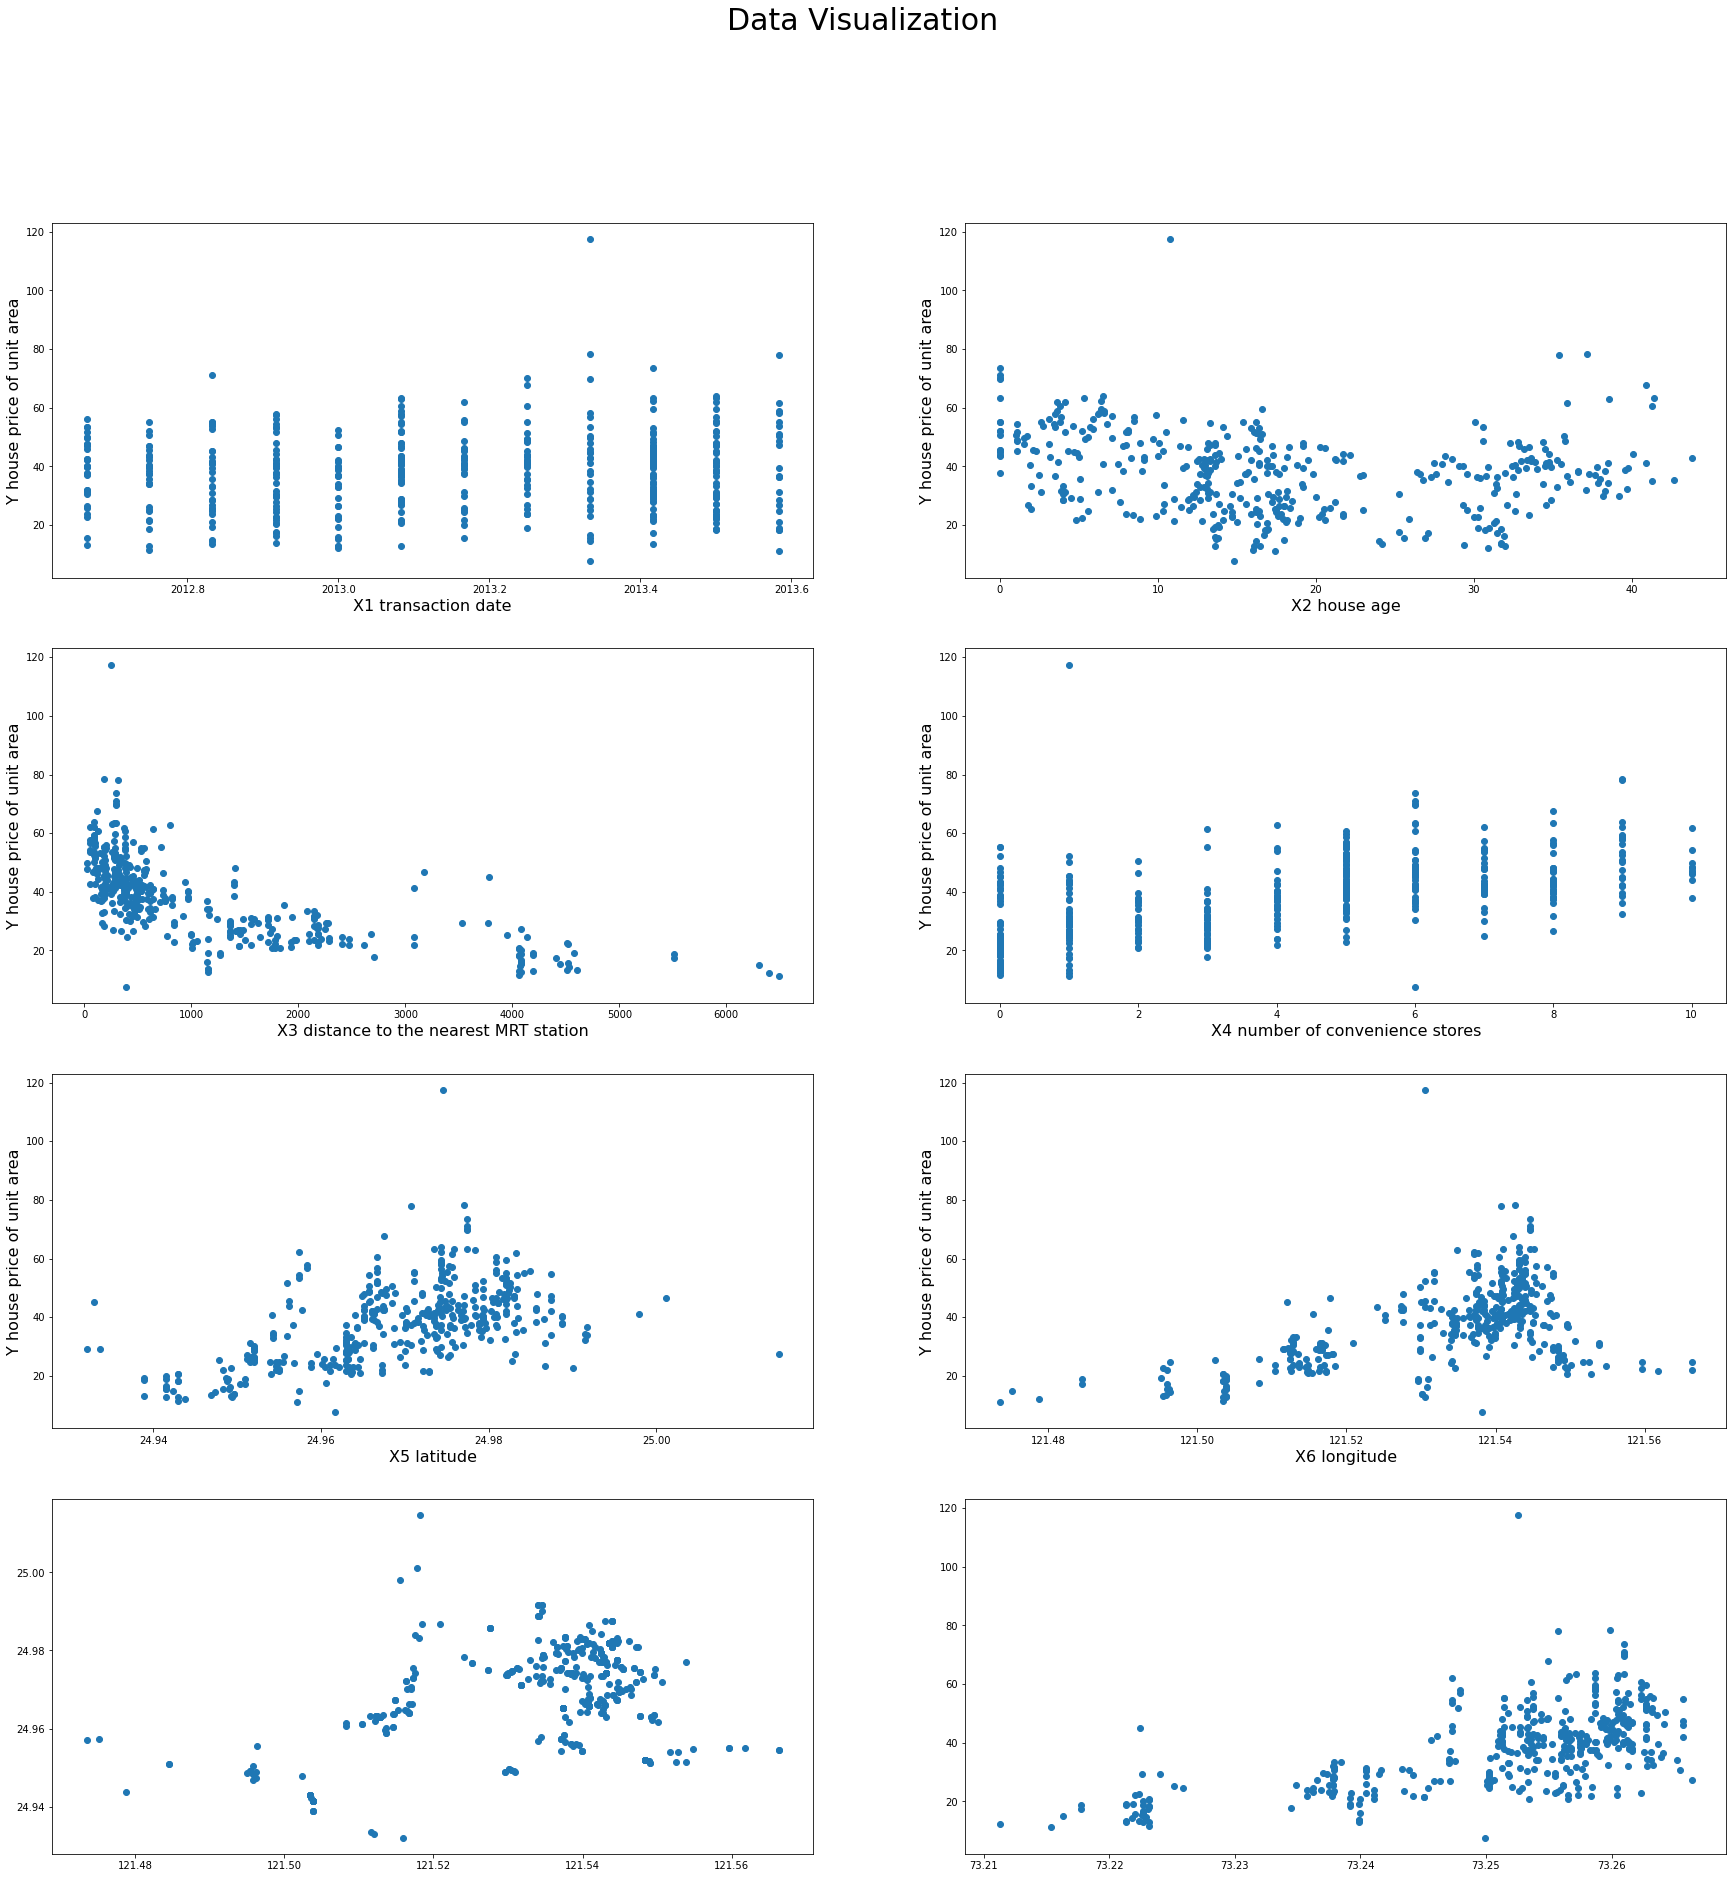

In [3]:
print(f"Number of columns: {data_df.shape[1]}")

# Plot data to identify trends
fig, axs = plt.subplots(4,2)

# Need a big figure
fig.set_size_inches(30, 30)

# Label figure
fig.suptitle("Data Visualization", fontsize = 30)
label = data_df.columns[-1]

i = 0
j = 0

# Plot each feature against the price/sqft
for feature in data_df.columns[1:-1]:
    axs[i,j].scatter(data_df[feature], data_df[label])
    axs[i,j].set_xlabel(feature, fontsize = 16)
    axs[i,j].set_ylabel(label, fontsize = 16)

    # These are not the droids you're looking for
    j += 1
    if j > 1:
        j = 0
        i += 1
    if i > 2:
        i = 0

# Plot by long/lat to see how the houses are arranged in the city    
axs[3,0].scatter(data_df["X6 longitude"], data_df["X5 latitude"])

# Experiment with averaging long/lat and ploting against housing per sqft
axs[3,1].scatter((data_df["X5 latitude"] + data_df["X6 longitude"])/2, data_df["Y house price of unit area"])

Longitude and latitude are combined together into a coordinate. While each seperately may yeild some information about the potential output, a combination of the two should give much more information about the output. We can plot longitude and latitude against the output using a 3-d plot. 

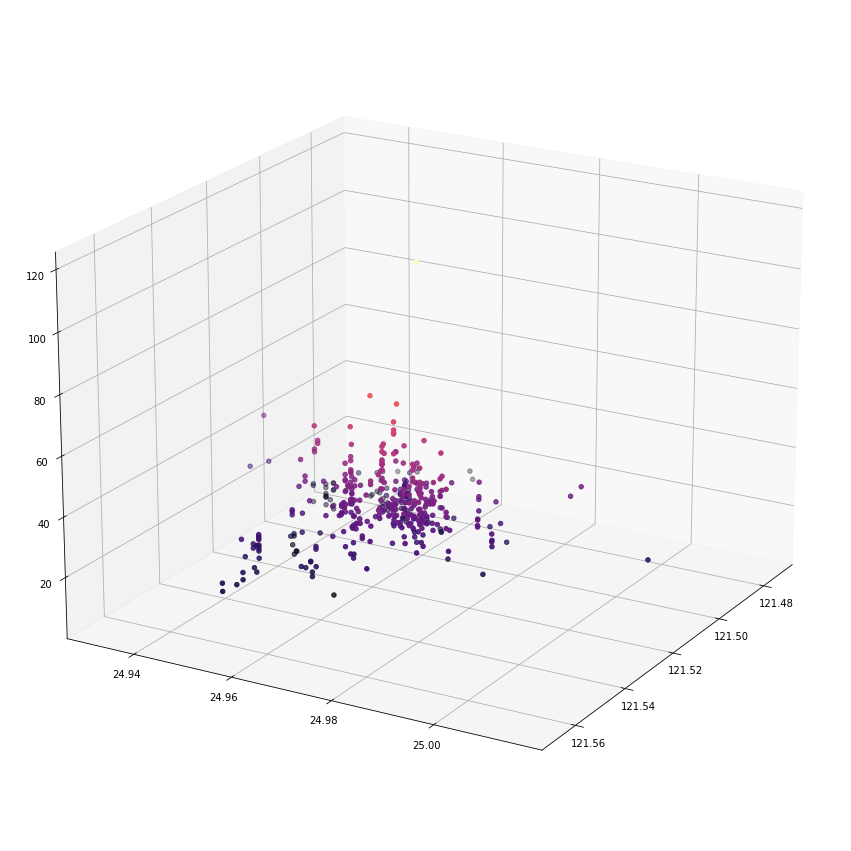

In [4]:
# Visualize a 3D plot of long/lat and housing price

fig = plt.figure(figsize = (15,30))
ax = fig.add_subplot(projection = '3d')
ax.scatter3D(data_df["X6 longitude"], data_df["X5 latitude"], data_df["Y house price of unit area"], c = data_df["Y house price of unit area"], cmap = 'magma')
ax.view_init(20, 30)


No single feature is strongly correlated with the observed outputs, however there are loose assosiciations that may allow us to find a linear association between the features and outputs. 

---

## Data Regularization
The next step in our project is to regularize the data. This reduces the spread of each features and reduces the range between features. I.e. if one feature is number of bedrooms (1-5), and another is total square footage (1000 - 5000), the difference in magnitude of each feature is enormous. By regularizing the data, we develop simlar scales between the data. 

In this step, we will also split the data into features and outputs and shuffle and divide the data into a training set and test set.

We will regularize the data using the equation:
$
\Large Z = \dfrac{\bar{X} - \mu}{\sigma}
$

In [5]:
# break down data for linear regression

# Regularization: z = (sample - mu)/sigma

# Convert dataframe to numpy array
data = data_df.to_numpy()

# toss the 'No' column, just lists the number of houses not a real datapoint
data = data[:,1:]

# Regularize features, not labels
x_data = data[:,:-1]

# find averages of each feature
mu = x_data.sum(axis=0)/data.shape[0]

# Calculate standard deviation of each feature
sigma = np.std(x_data, axis=0)

# regularize
r_data = (x_data-mu)/sigma

# Append column of 1s for bias
r_data = np.c_[np.ones(r_data.shape[0]), r_data]


In [6]:
# Show Old Data
data_df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [7]:
# View new Data
pd.DataFrame(r_data, columns=['bias', 'transaction date', 'house age', 'distance to MRT', 'number of convenience stores', 'latitude', 'longitude'])[:10]

,bias,transaction date,house age,distance to MRT,number of convenience stores,latitude,longitude
0,1.0,-0.823683,1.255628,-0.792495,2.007407,1.125430,0.448762
1,1.0,-0.823683,0.157086,-0.616612,1.667503,0.912444,0.401139
2,1.0,1.541151,-0.387791,-0.414015,0.307885,1.486860,0.688183
3,1.0,1.246435,-0.387791,-0.414015,0.307885,1.486860,0.688183
4,1.0,-1.121951,-1.117223,-0.549997,0.307885,0.834188,0.592937
5,1.0,-1.711384,-0.932668,0.865586,-0.371925,-0.482451,-1.358313
6,1.0,-1.711384,1.475337,-0.365237,0.987694,0.830961,0.199555
7,1.0,0.951718,0.227393,-0.631678,0.647789,0.918898,0.581846
8,1.0,1.246435,1.229263,3.512777,-1.051734,-1.458635,-3.182350
9,1.0,0.951718,0.016473,0.554738,-0.371925,-0.138769,-1.206962


---
## Splitting Data

Next, we must partition the data so we can train on a subset, then test and verify our model with a partition the model was not tuned on. This enhances our ability to know if our model has overfit the training data and understand the accuracy of future predictions. here, we will partition 2/3rds of the data to train on, and 1/3 of the data to test and verify on. 

In [8]:
# Split data into x = features and y = labels
y = data[:,-1]

X = r_data
#X = X[:,1:]
# Split into train, validate, test data. Shuffle data for better results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle=True, random_state=42)

In [61]:
# Define Useful Functions
# Squared Error
def MSE(y_hat, y):
    return np.round((1/y.shape[0])*(sum((y_hat - y)**2)),3)

def grad(X, error):
    X = np.array(X)
    return (2/X.shape[0])*(X.T @ (error))

def train_stoch(X, y, alpha, threshold):
    all_theta = []
    all_MSE = []

    theta = np.random.randn(X_train.shape[1])*np.sqrt(2)
    all_MSE.append(MSE(X @ theta, y))
    all_theta.append(theta)
    
    delta_w = np.zeros(theta.shape)

    np.random.seed(1)
    p = np.random.permutation(X.shape[0])

    i = 0 
    MSE_diff = 100 

    while (i < 1000) & (MSE_diff >= threshold):
        for vector, result in zip(X[p,:], y[p]):
            vector = np.array(vector)
            result = np.array(result)

            delta_w = alpha * grad([vector],[(vector.T @ theta)- result])
            theta = theta-delta_w
            
        all_theta.append(theta)
        all_MSE.append(MSE(X @ theta, y))
        MSE_diff = np.abs(all_MSE[-1] - all_MSE[-2])

    return all_theta, all_MSE

def train_batch(X, y, alpha, threshold):
    all_theta = []
    all_MSE = []

    # Randomly initialize theta
    theta = np.random.randn(X.shape[1])*np.sqrt(2)
    all_theta.append(theta)

    # Calculate the MSE
    all_MSE.append(MSE((X @ theta), y))

    # Train by Gradient Descent
    i = 0 
    MSE_diff = 100 

    while (i < 1000) & (MSE_diff >= threshold):
        # Update weights
        delta = grad(X, ((X @ theta) - y))
        theta = theta - alpha*delta

        # Record Keeping
        all_theta.append(theta)
        all_MSE.append(MSE((X @ theta), y))

        MSE_diff = np.abs(all_MSE[-1] - all_MSE[-2])

    return all_theta, all_MSE

def train_mini_batch(X, y, alpha, batch_size, threshold):
    all_theta = []
    all_MSE = []

    # Randomly initialize theta
    theta = np.random.randn(X.shape[1])*np.sqrt(2)
    all_theta.append(theta)

    # Calculate the MSE
    all_MSE.append(MSE((X @ theta), y))

    # Train by Gradient Descent
    i = 0 
    MSE_diff = 100 

    while (i < 1000) & (MSE_diff >= threshold):

        for i in range(0, X.shape[0], batch_size):
            X_part = X[i:i + batch_size]
            y_part = y[i:i + batch_size]

            # Update weights
            delta = grad(X_part, ((X_part @ theta) - y_part))
            theta = theta - alpha*delta

        # Record Keeping
        all_theta.append(theta)
        all_MSE.append(MSE((X @ theta), y))

        MSE_diff = np.abs(all_MSE[-1] - all_MSE[-2])

    return all_theta, all_MSE

In [161]:
class gradient_descent():
    def __init__(self, alpha = 0.005, algorithm='Batch', threshold = 0.01, hist = True):
        self.alpha = alpha
        self.algorithm = algorithm
        self.threshold = threshold
        self.hist = hist


    def train(self, X, y, batch_size = 50):
        all_MSE = []
        all_theta = []
        
        if(self.algorithm == 'Batch'):
            all_theta, all_MSE = train_batch(X, y, self.alpha, self.threshold)

        elif(self.algorithm == 'Stochiastic'):
            all_theta, all_MSE = train_stoch(X, y, self.alpha, self.threshold)

        elif(self.algorithm == 'Mini_Batch'):
            all_theta, all_MSE = train_mini_batch(X, y, self.alpha, batch_size, self.threshold)
        else:
            print('Error! Algorithm doesn\'t match')

        all_MSE = np.array(all_MSE)
        print(f"Final MSE: {all_MSE[-1]}")
        print(f"Number of iterations: {all_MSE.shape[0]}")

        if self.hist == True:

            fig, ax = plt.subplots(1,2)
            fig.suptitle(str(self.algorithm), fontsize = 40)
            fig.set_size_inches(30,15)
            fig.set_tight_layout(True)
            ax[0].plot(range(all_MSE.shape[0]),all_MSE, marker='o')
            ax[0].set_title("Alpha = " + str(self.alpha), fontsize = 20)
            ax[0].set_xlabel("Iteration", fontsize = 15)
            ax[0].set_ylabel("MSE", fontsize = 15)

            line1 = 'Initial MSE: ' + str(np.round(all_MSE[0],2))
            line2 = 'Final MSE: ' + str(np.round(all_MSE[-1],2))
            line3 = 'Number of Iterations: ' + str(np.round(all_MSE.shape[0],2))
            text = line1 + '\n' + line2 + '\n' + line3

            yticks = ax[0].get_yticks()
            xticks = ax[0].get_xticks()
       
            ax[0].text(xticks[-1]/2, yticks[-3], text, fontsize = 20)

            ax[1].plot(range(all_MSE.shape[0]), all_theta, 
                            label = ['bias', 'transaction date', 'house age', 'distance to MRT', 
                                     'number of convenience stores', 'latitude', 'longitude'])

            ax[1].set_title('Theta vs Iteration', fontsize = 15)
            ax[1].set_xlabel('Iteration', fontsize = 15)
            ax[1].set_ylabel('Theta', fontsize = 15)
            ax[1].legend()


Final MSE: 110.641
Number of iterations: 9960
Final MSE: 87.581
Number of iterations: 2873
Final MSE: 84.93
Number of iterations: 1590
Final MSE: 82.87
Number of iterations: 428
Final MSE: 81.325
Number of iterations: 218
Final MSE: 81.284
Number of iterations: 85
Final MSE: 81.104
Number of iterations: 50


C:\Users\carmi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
C:\Users\carmi\AppData\Local\Temp/ipykernel_25980/4228269982.py:4: RuntimeWarning: overflow encountered in double_scalars
  return np.round((1/y.shape[0])*(sum((y_hat - y)**2)),3)
C:\Users\carmi\AppData\Local\Temp/ipykernel_25980/4228269982.py:64: RuntimeWarning: invalid value encountered in double_scalars
  MSE_diff = np.abs(all_MSE[-1] - all_MSE[-2])


Final MSE: inf
Number of iterations: 728


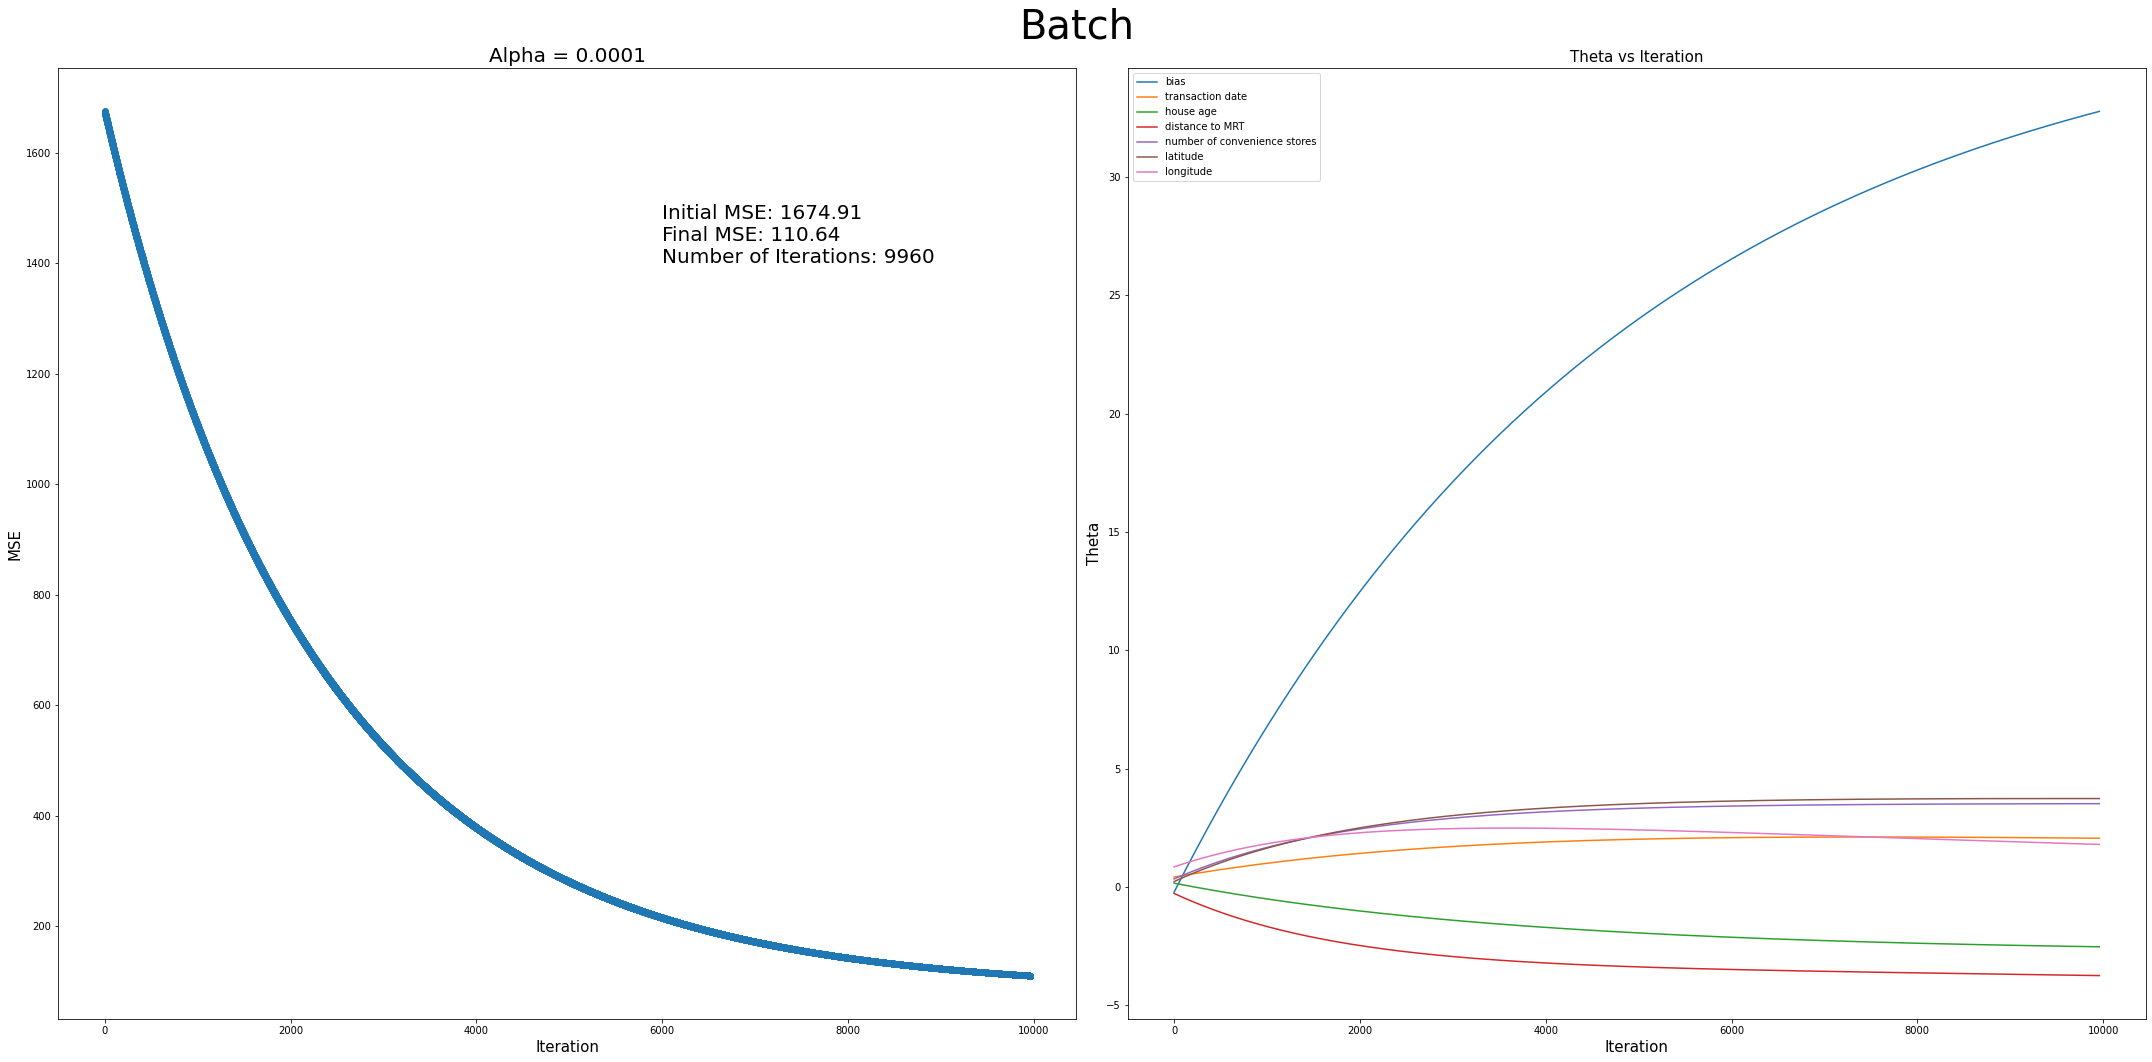

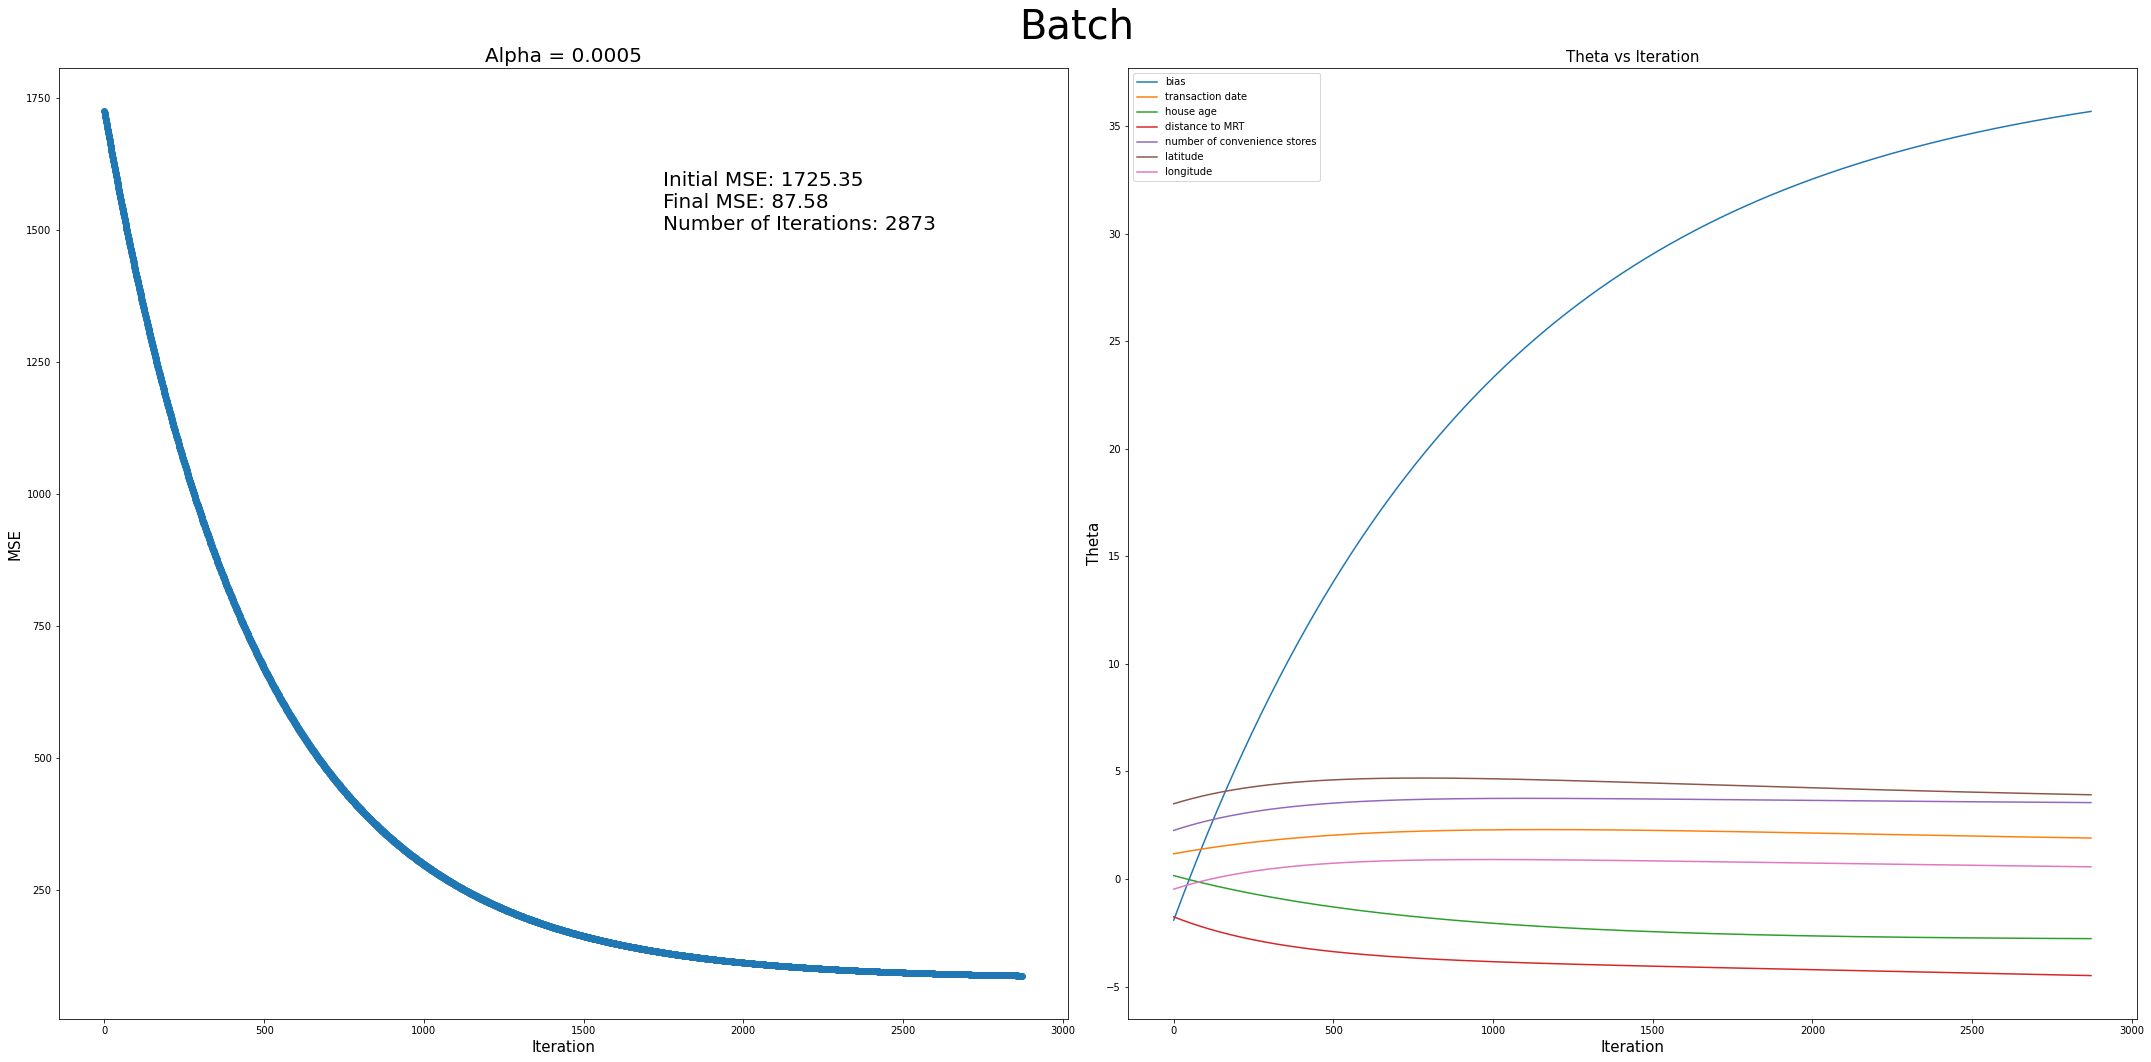

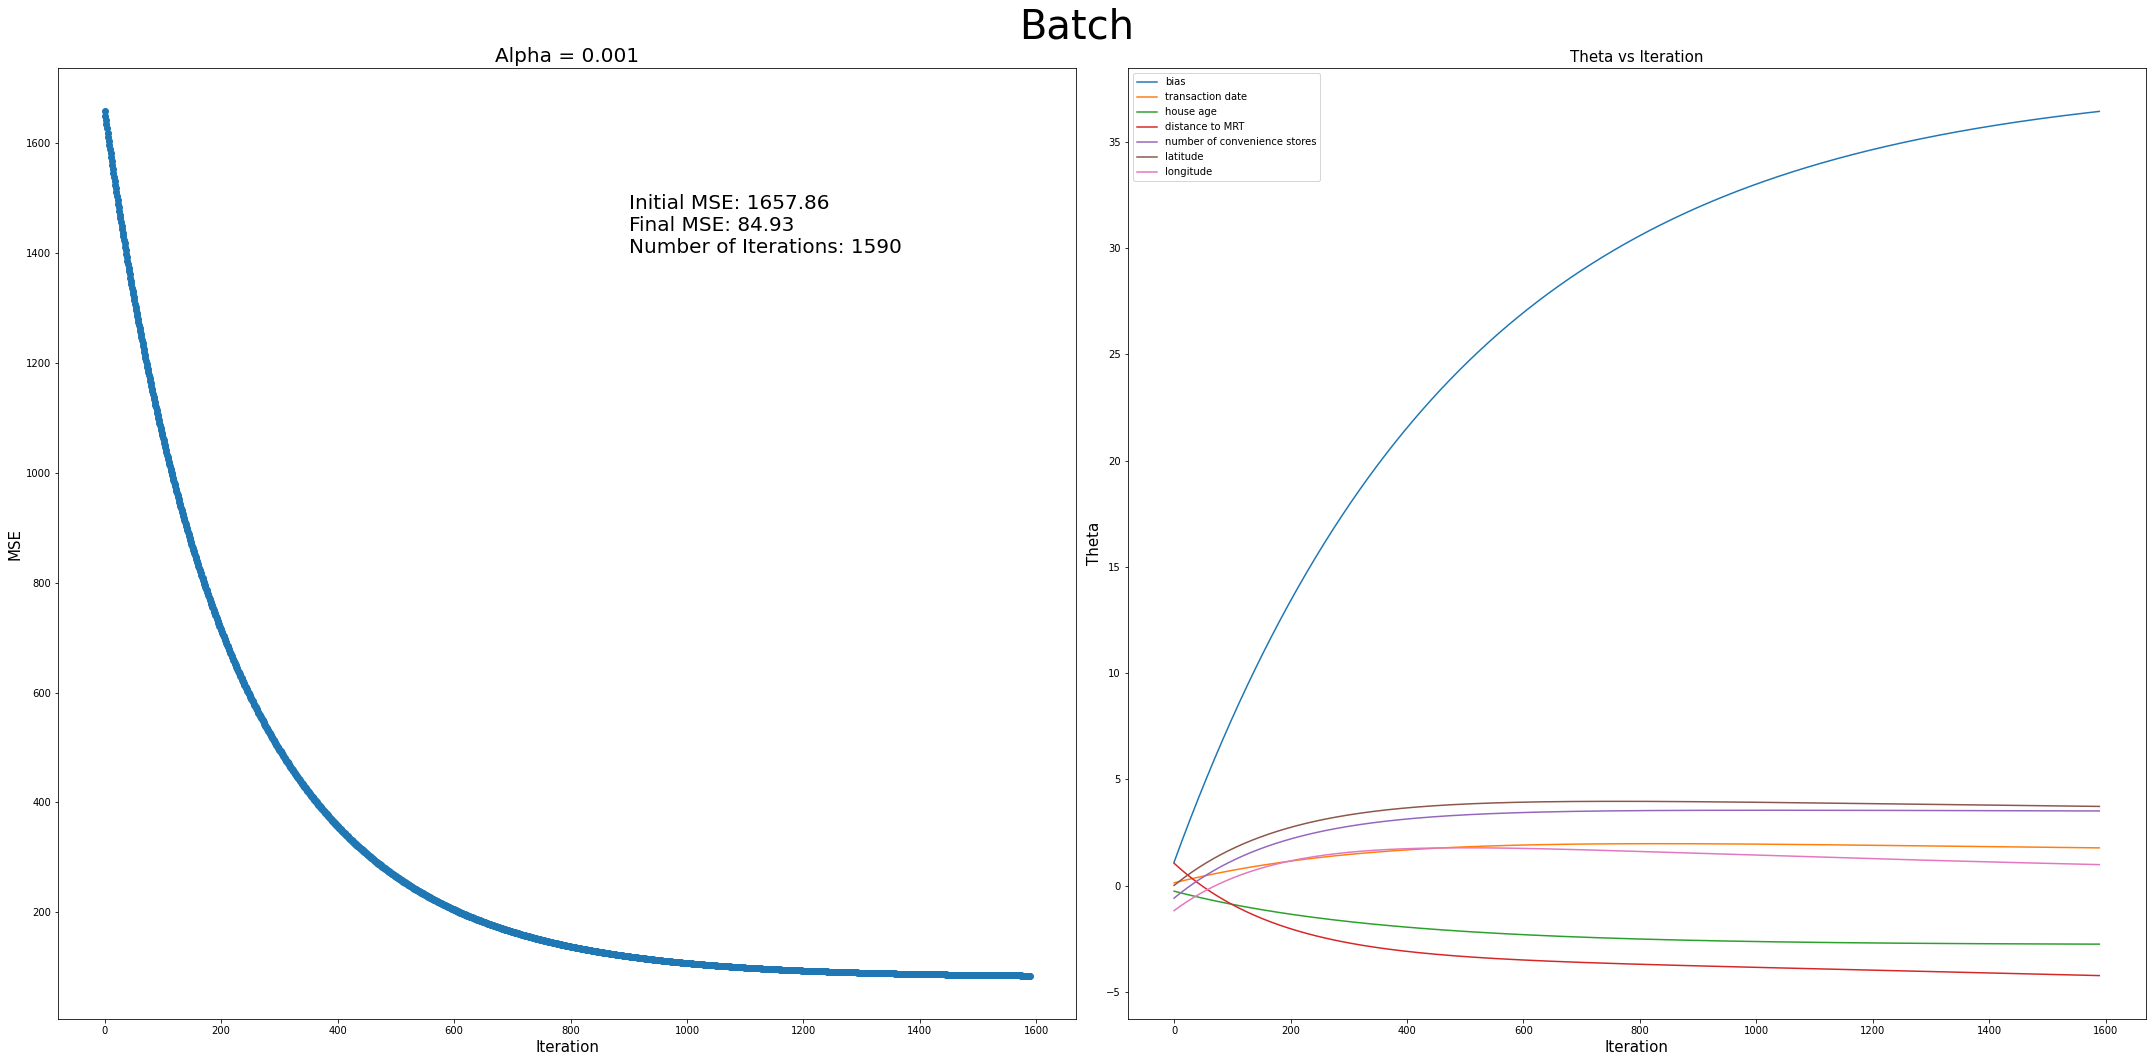

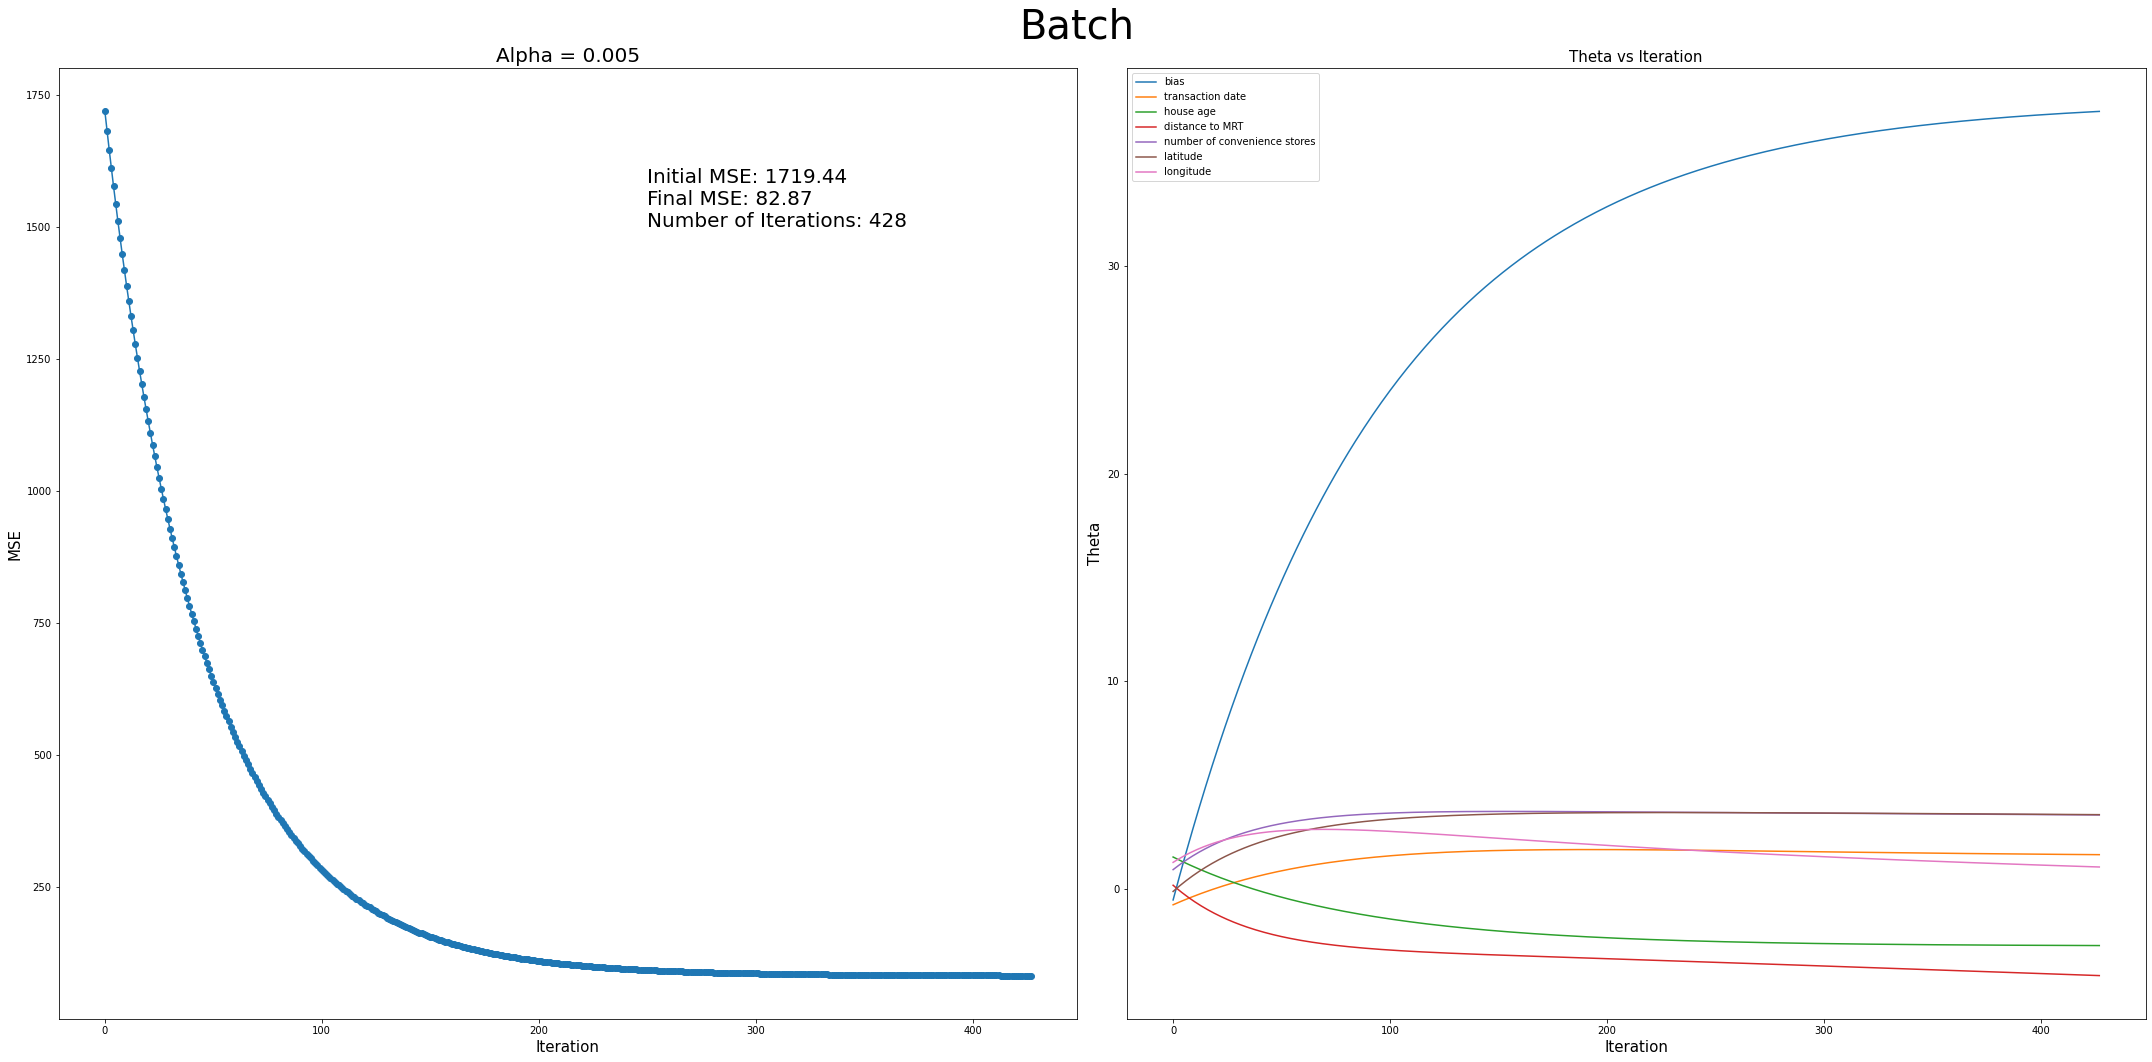

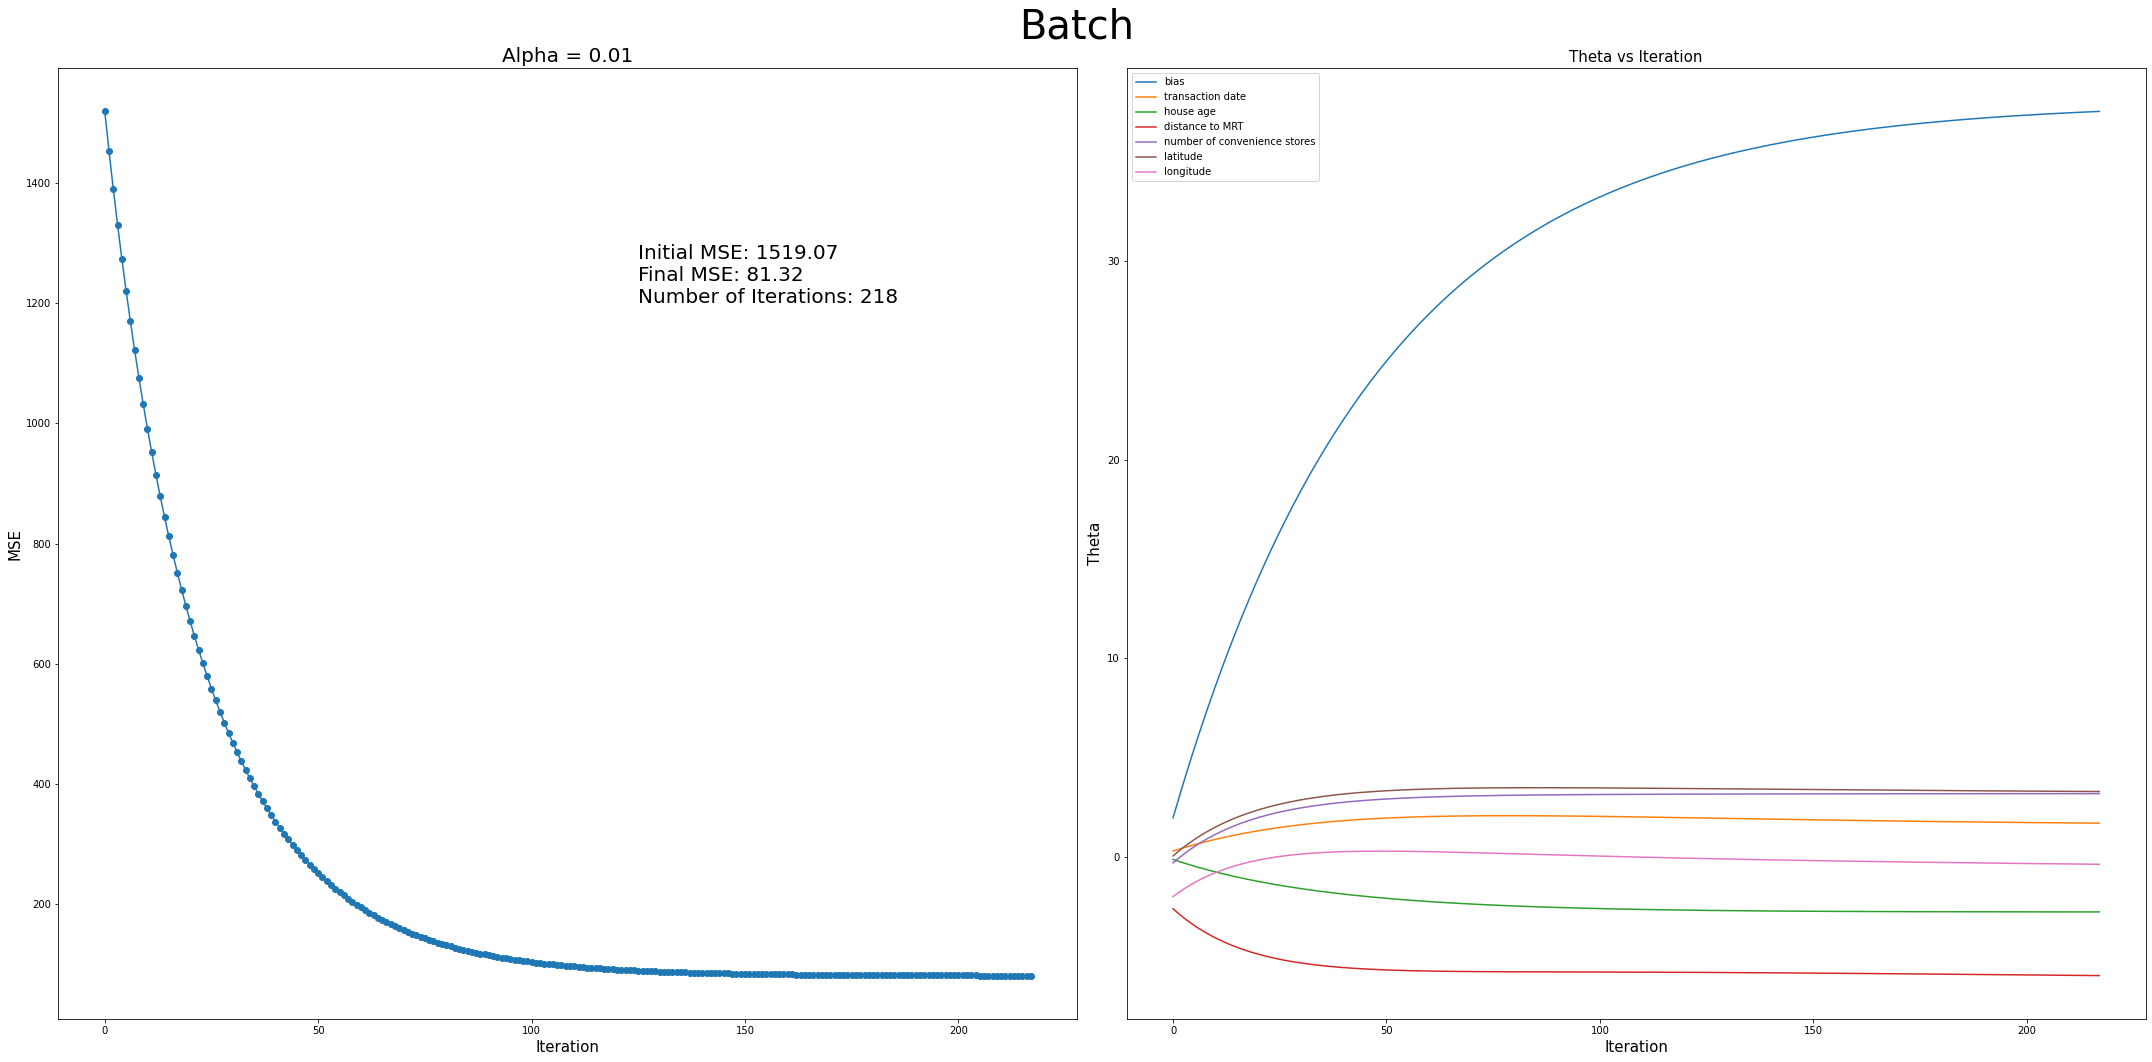

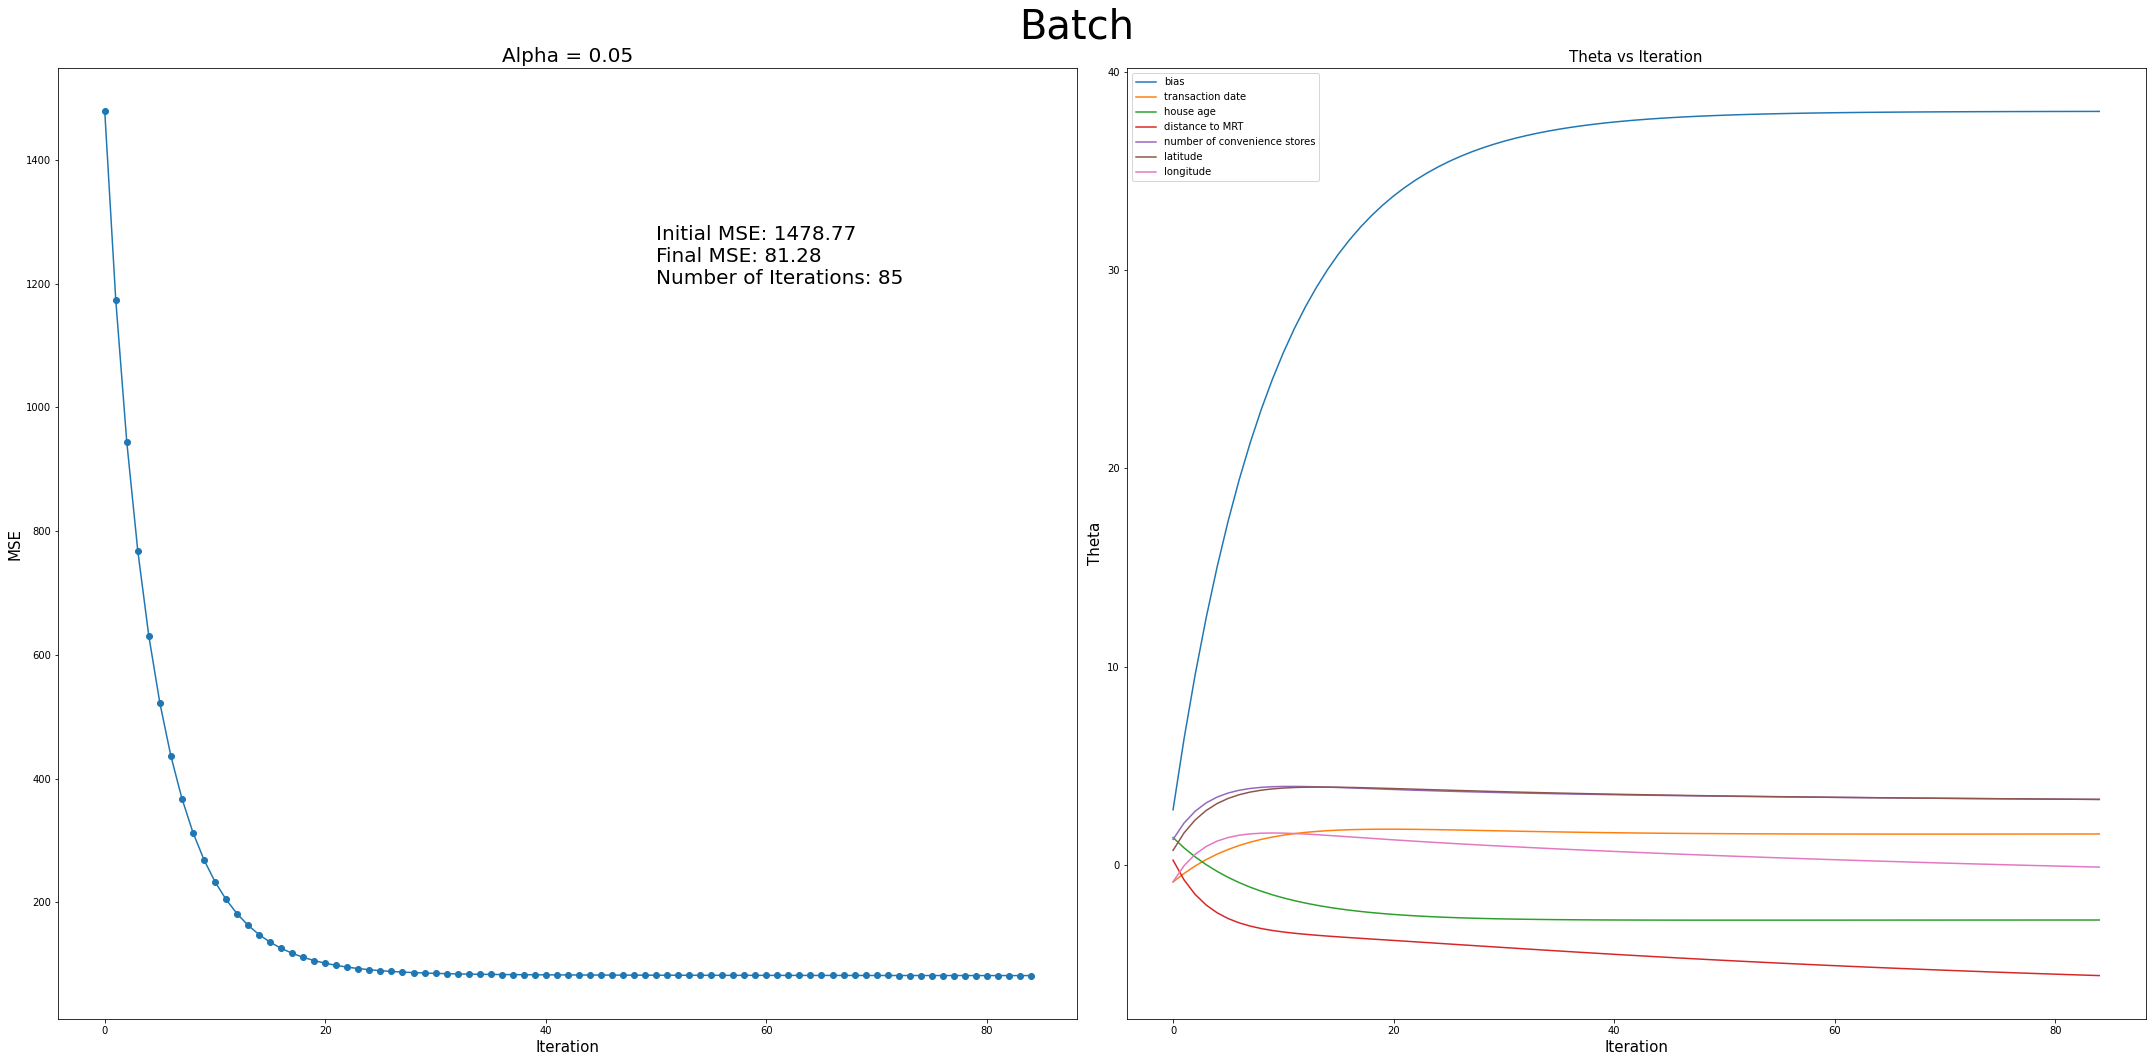

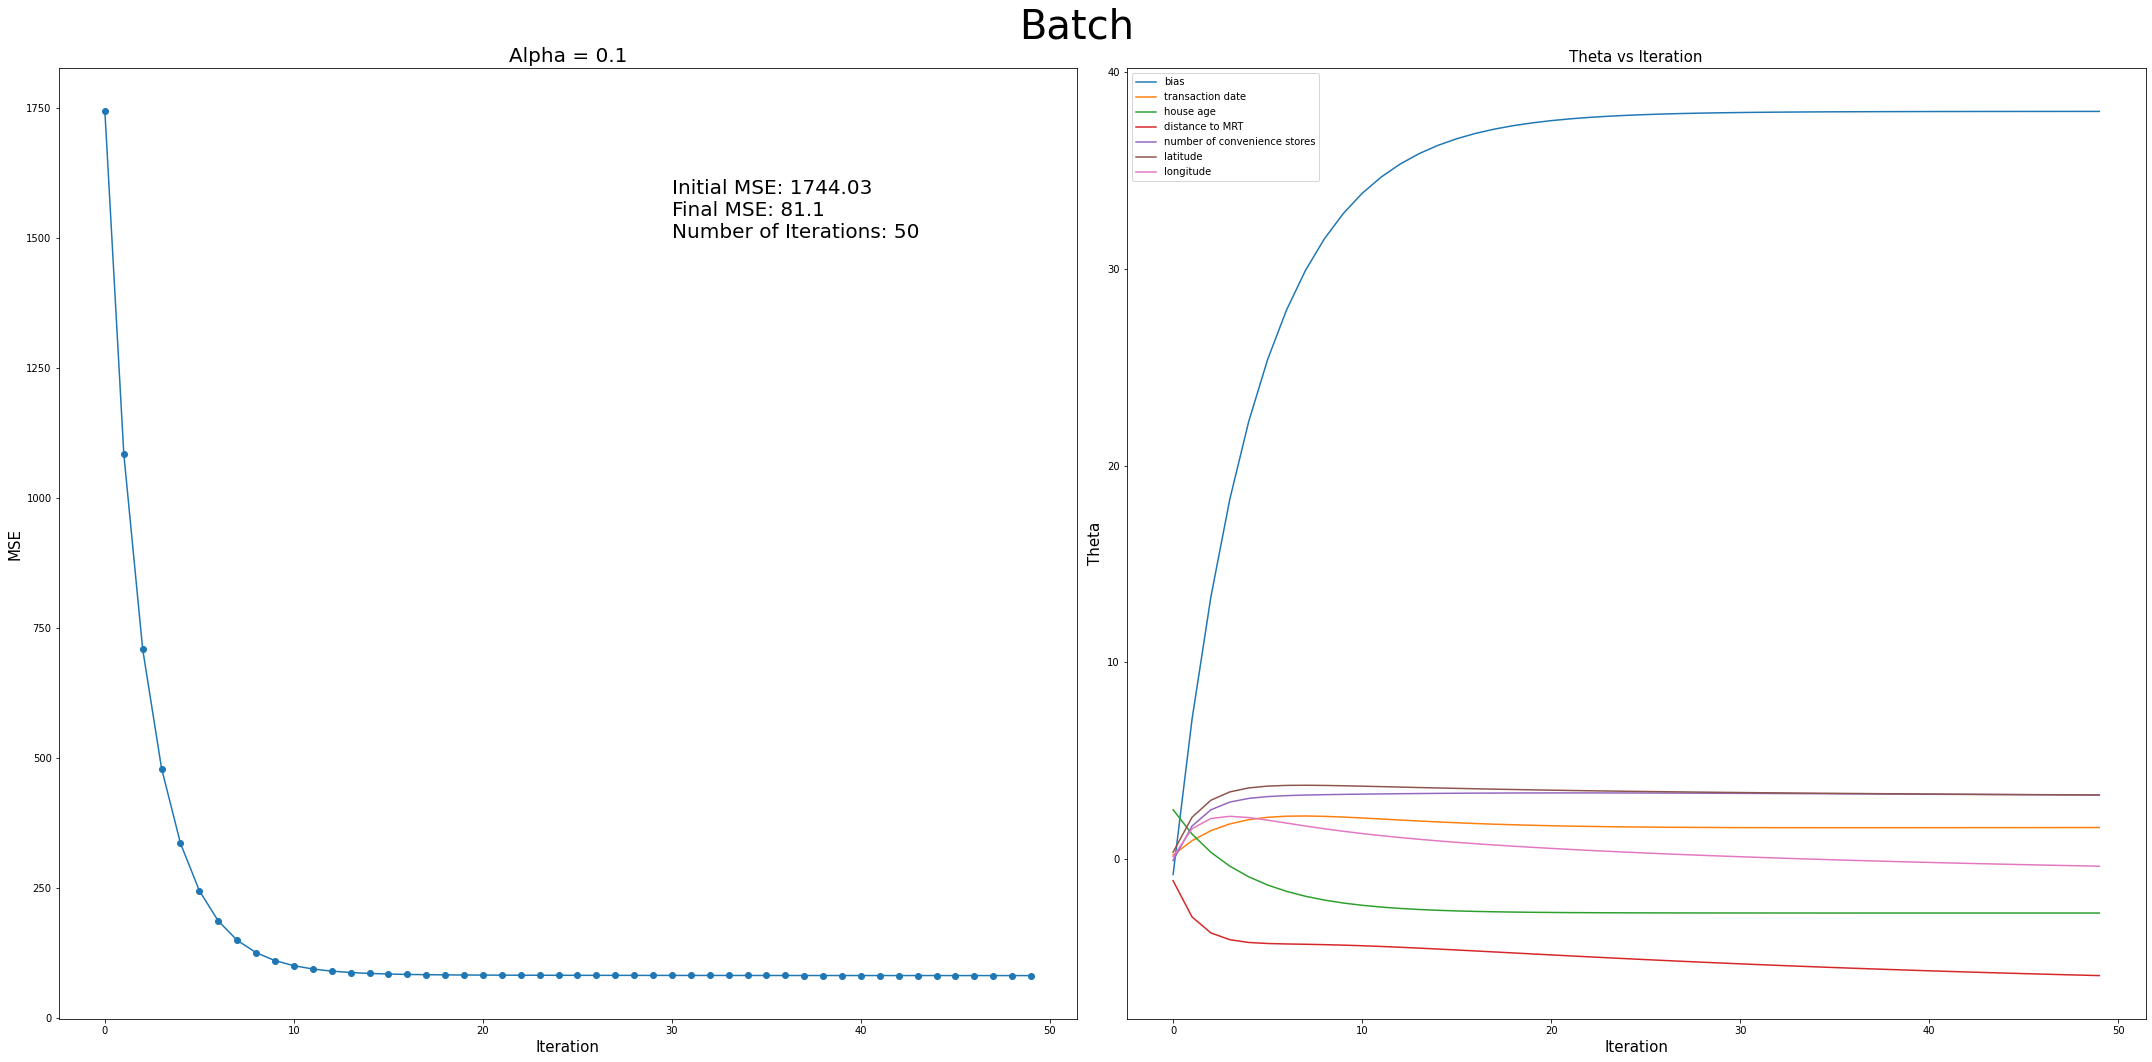

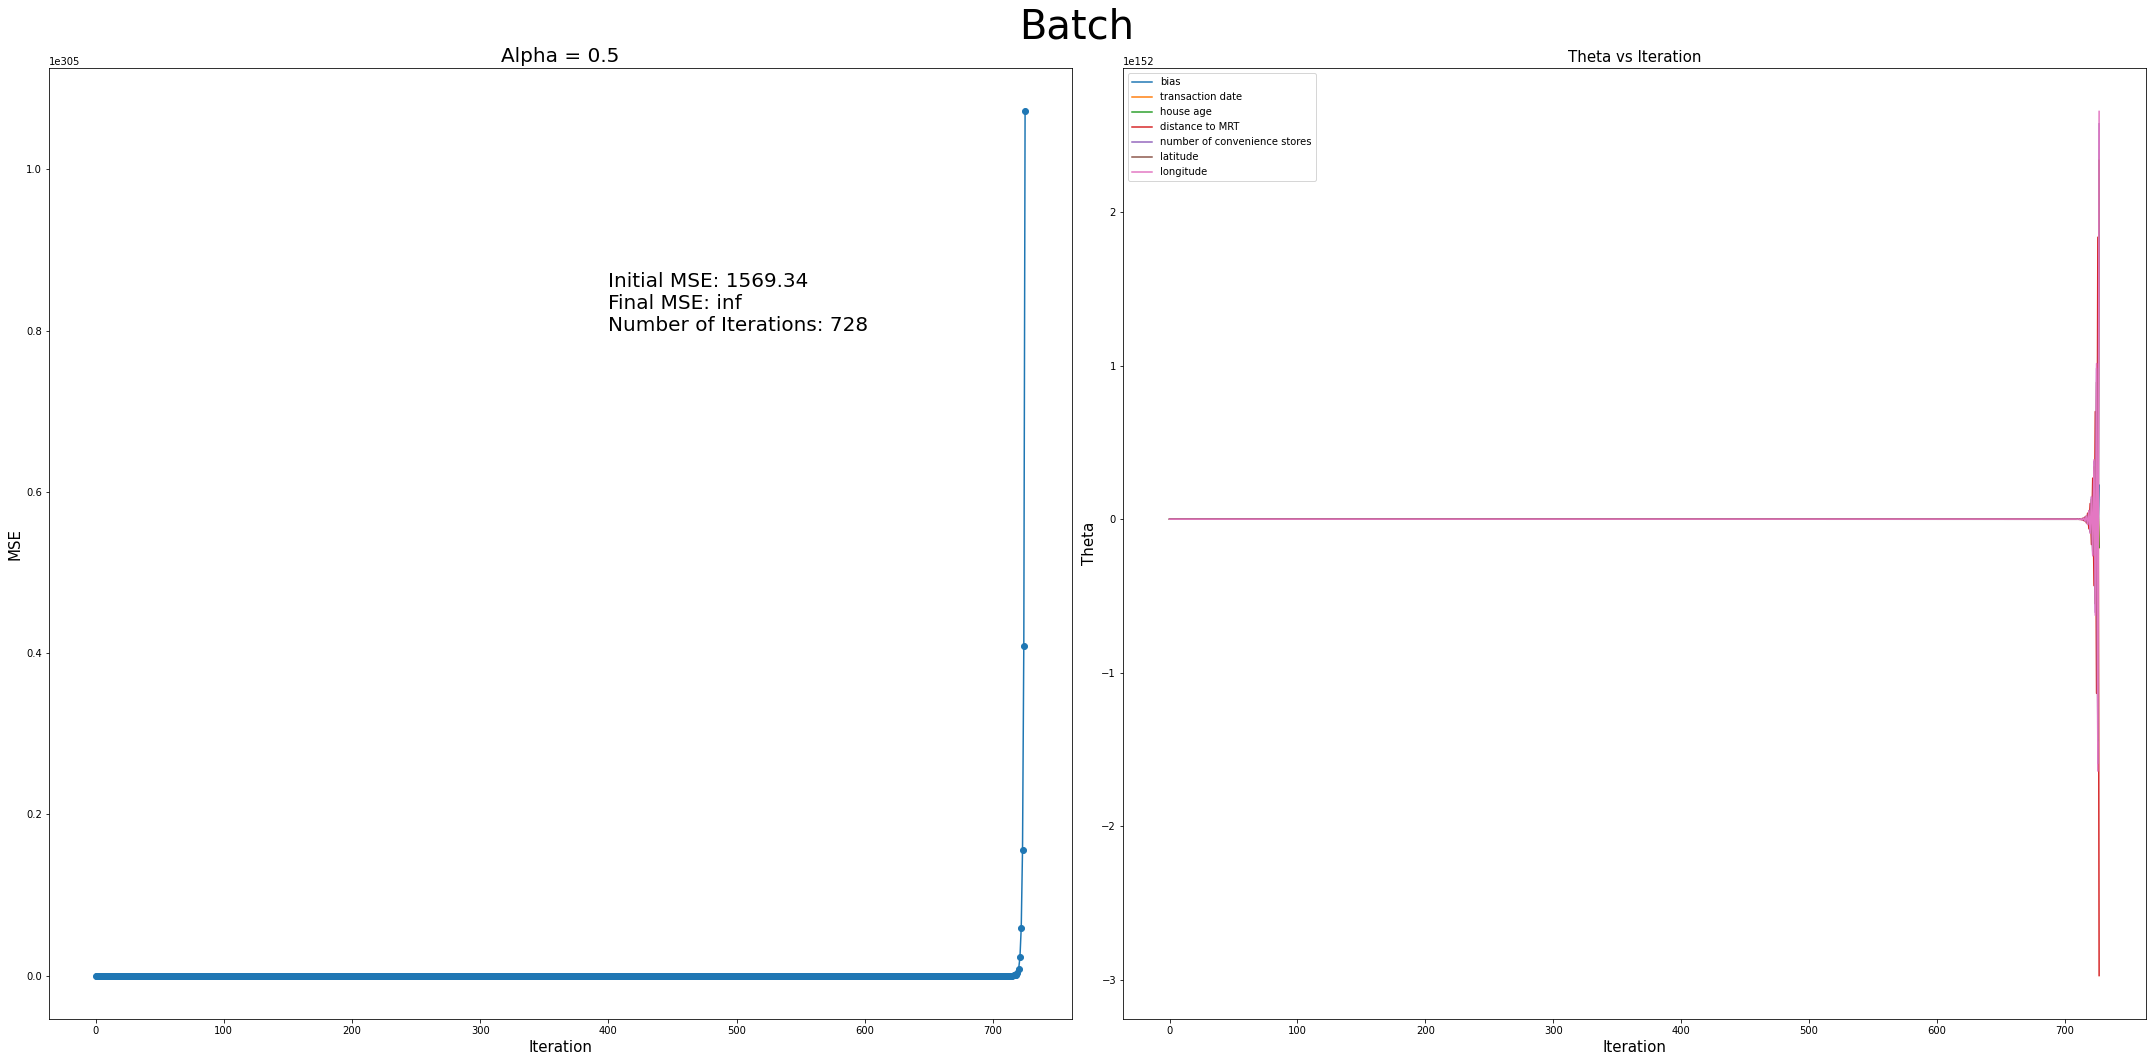

In [153]:
# Tune alpha
alpha = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

for rate in alpha:
    model = gradient_descent(alpha=rate)
    model.train(X_train, y_train)

Above, the left graphs plot the MSE vs the iteration. All alpha below 0.001 reach the maximum nuumber of iterations before reaching the breakout condition of $\Large\varepsilon_n - \varepsilon_{n-1} \normalsize\leq 0.01$. This means the learning rate is too small, taking too long and the algorithm is taking too long to reach the minimum. Alpha between 0.005 and 0.1 Converge to a solution in less time than the iterations, with the fastest convergence of alpha = 0.1. 

When Alpha = 0.5, the learning rate is to large, and the MSE increases towards infinity. Each step overshoots the minimum causing the errors to get worse and worse. 

---
# Variants
There are 3 major approaches to gradient descent: batch, stochiastic, and min-batch. 

## Batch Gradient Descent
Batch gradient descent calculates the gradient of the cost function wieth respect to $\theta$ for the entire set at once using the equation:

$
\nabla_{\theta} J(\theta) = \frac{1}{m}\sum_{i=1}^m[(\hat{y}^i - y^i)*x^i]
$

which is used to update $\theta$ following:

$
\theta = \theta - \alpha\nabla_{\theta} J(\theta)
$

Batch gradient descent requires the gradients for *entire* dataset to be calculated for each step. While this is not an issue for many practical datasets, it is important to keep in mind as datasets and features grow larger. Batch gradient descent could cause time and memory allocation issues for large datasets. Another potential issue with batch gradient descent is that it will converge to the first local minimum in the direction of the initial step. This can risk can be mitigated by running the algorithm multiple times with random starting points and comparing the end costs of each run. 


Final MSE: 81.102
Number of iterations: 45


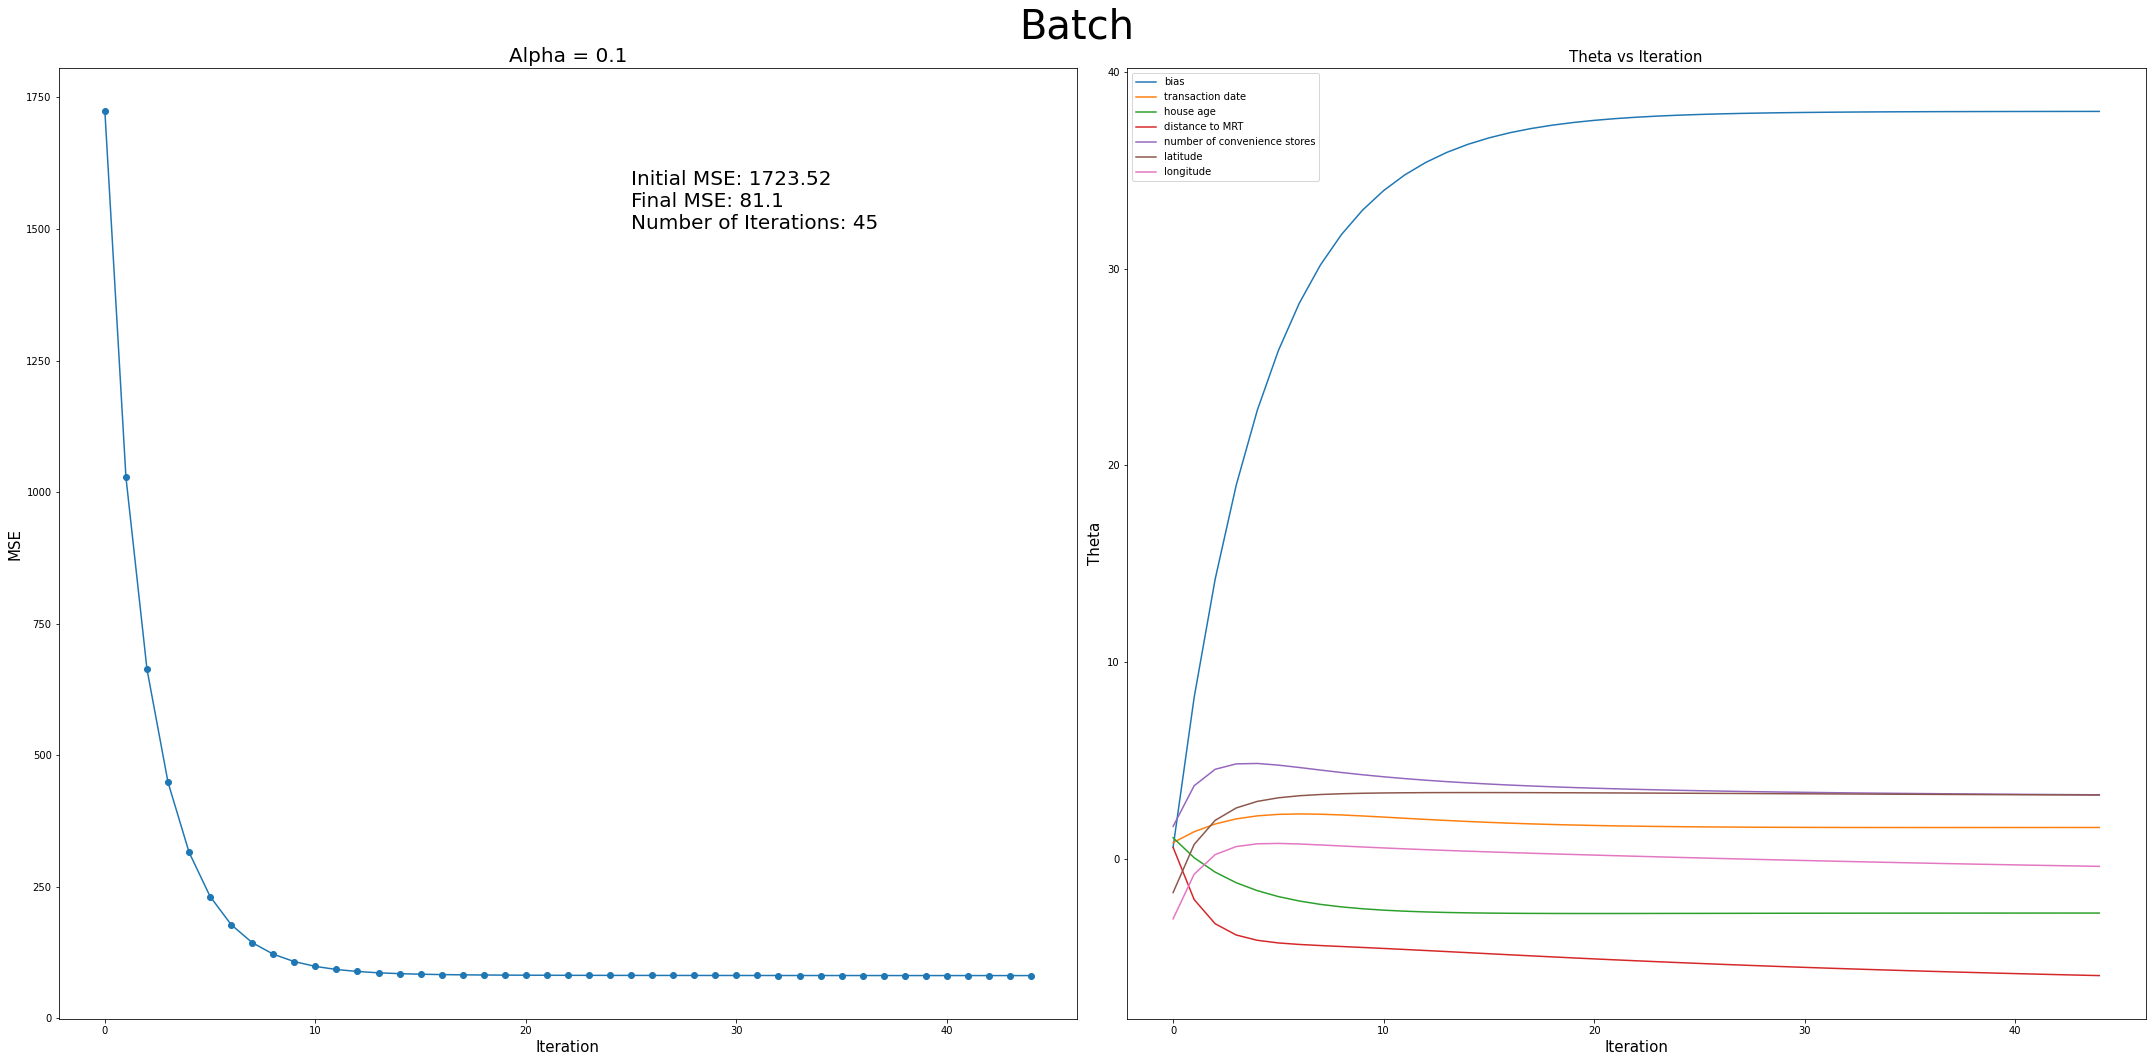

In [154]:
model = gradient_descent(alpha=0.1, algorithm = 'Batch')
model.train(X_train, y_train)

## Stochiastic Gradient Descent
$
\theta = \theta - \alpha\nabla_{\theta} J(\theta; x^{i}; y^{i})
$

Where batch gradient descent calculates the gradient of the entire series, stochiastic gradient descent calculates the gradient on of one randomly selected feature vector of the dataset, taking a step in the direction that minimizes its error with respect to $\theta$. Stochiastic gradient descent itself is not an efficient way to find the value of $\theta$ that minimizes $J(\theta)$, however decreasing the learning rate $\alpha$ each iteration can allow it to converge to local or global minimums. This randomness, however, does provide a benefit in that stochiastic gradient descent is less likely to get "stuck" at the first local minimum. 



Final MSE: 81.07
Number of iterations: 47


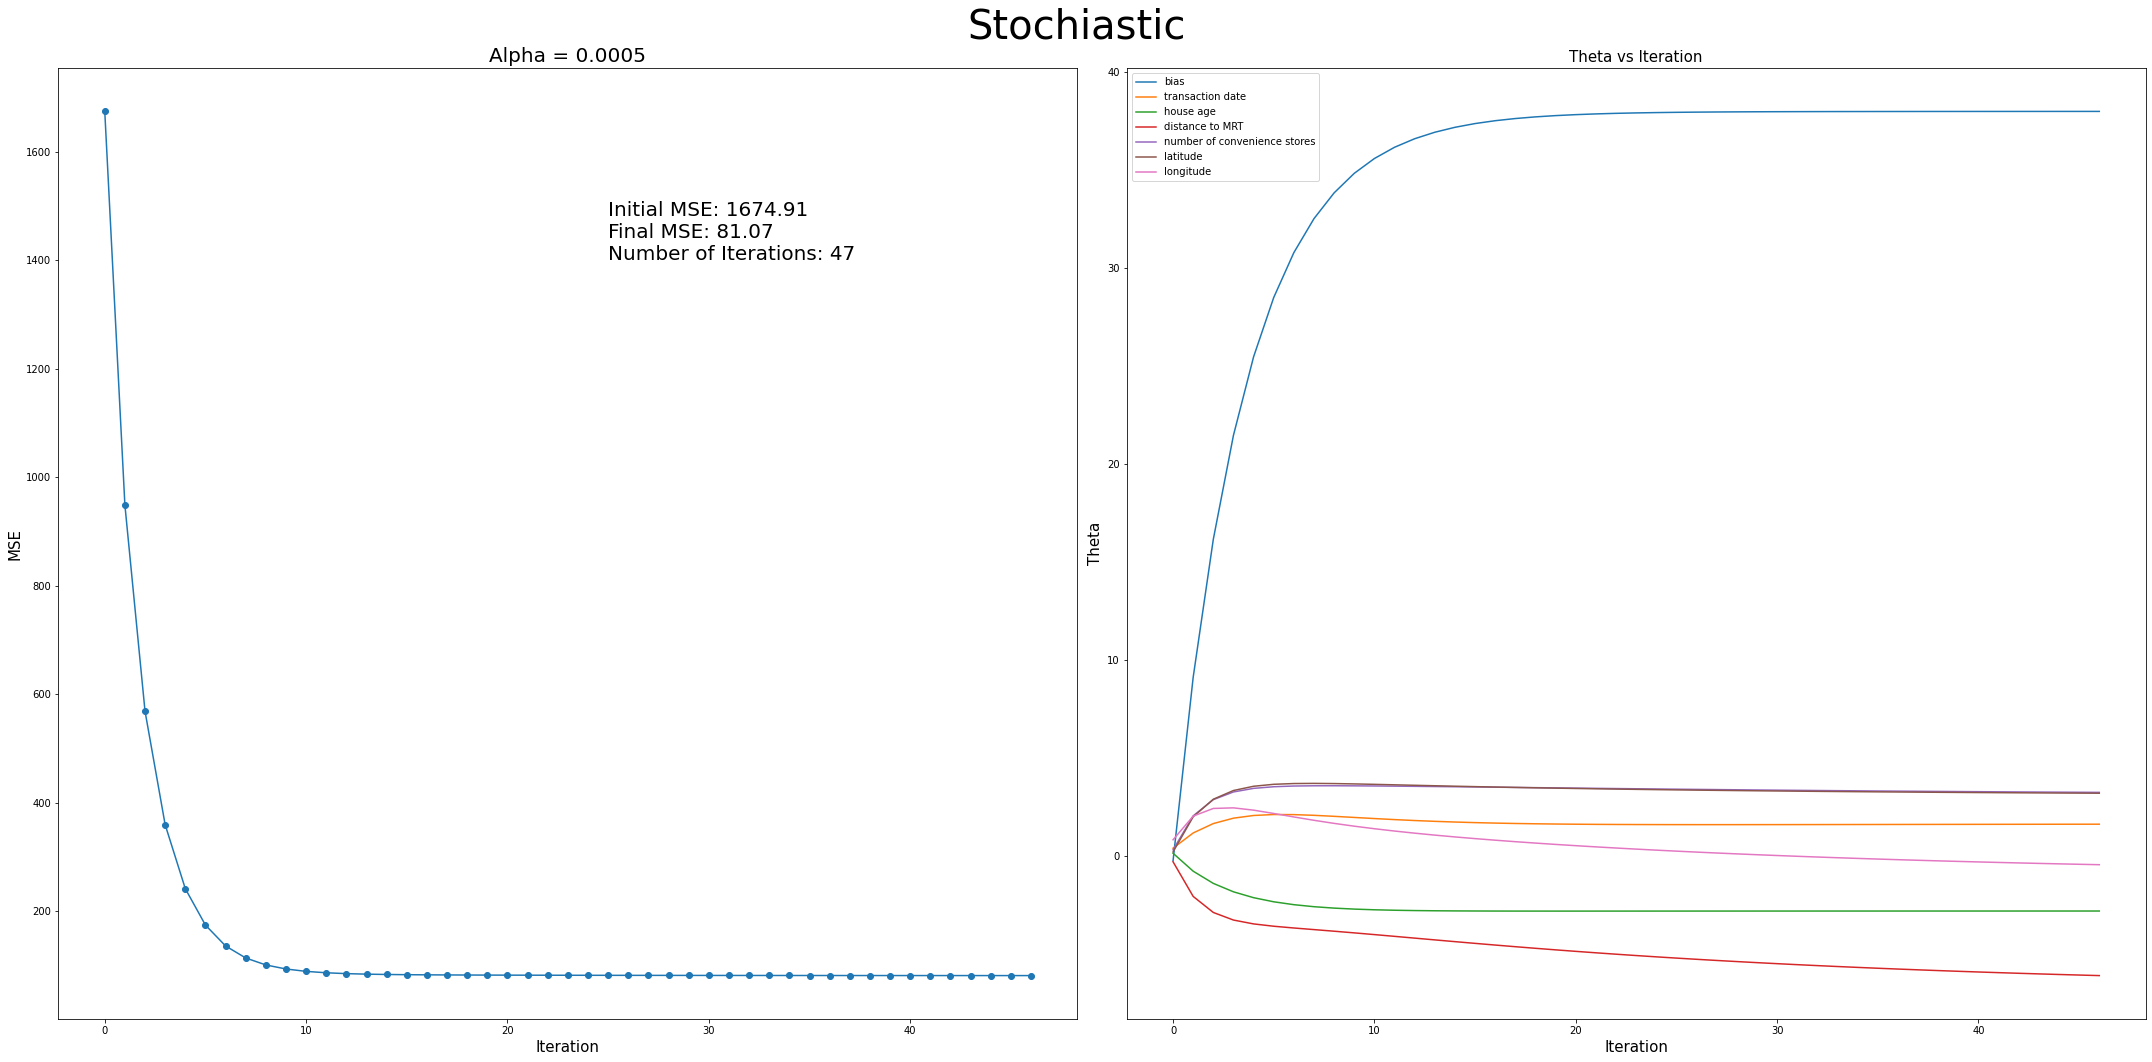

In [158]:
model = gradient_descent(alpha=0.0005, algorithm = 'Stochiastic')
model.train(X_train, y_train)

## Mini Batch Gradient Descent
$
\theta = \theta - \alpha\nabla_{\theta} J(\theta; x^{i:i+n}; y^{i:i+n})
$

Mini-batch gradient descent combines the increased efficacy of batch gradient descent with the reduced computational complexity and randomness of stochiastic gradient descent. Mini-batch gradient descent randomly selects feature vectors i to i+n where n is some pre-defined length and calculates the gradient. This reduces the chaotic nature of choosing only one feature vector to calculate the gradient, but reduces the total number of calculations required. 

Final MSE: 82.424
Number of iterations: 11


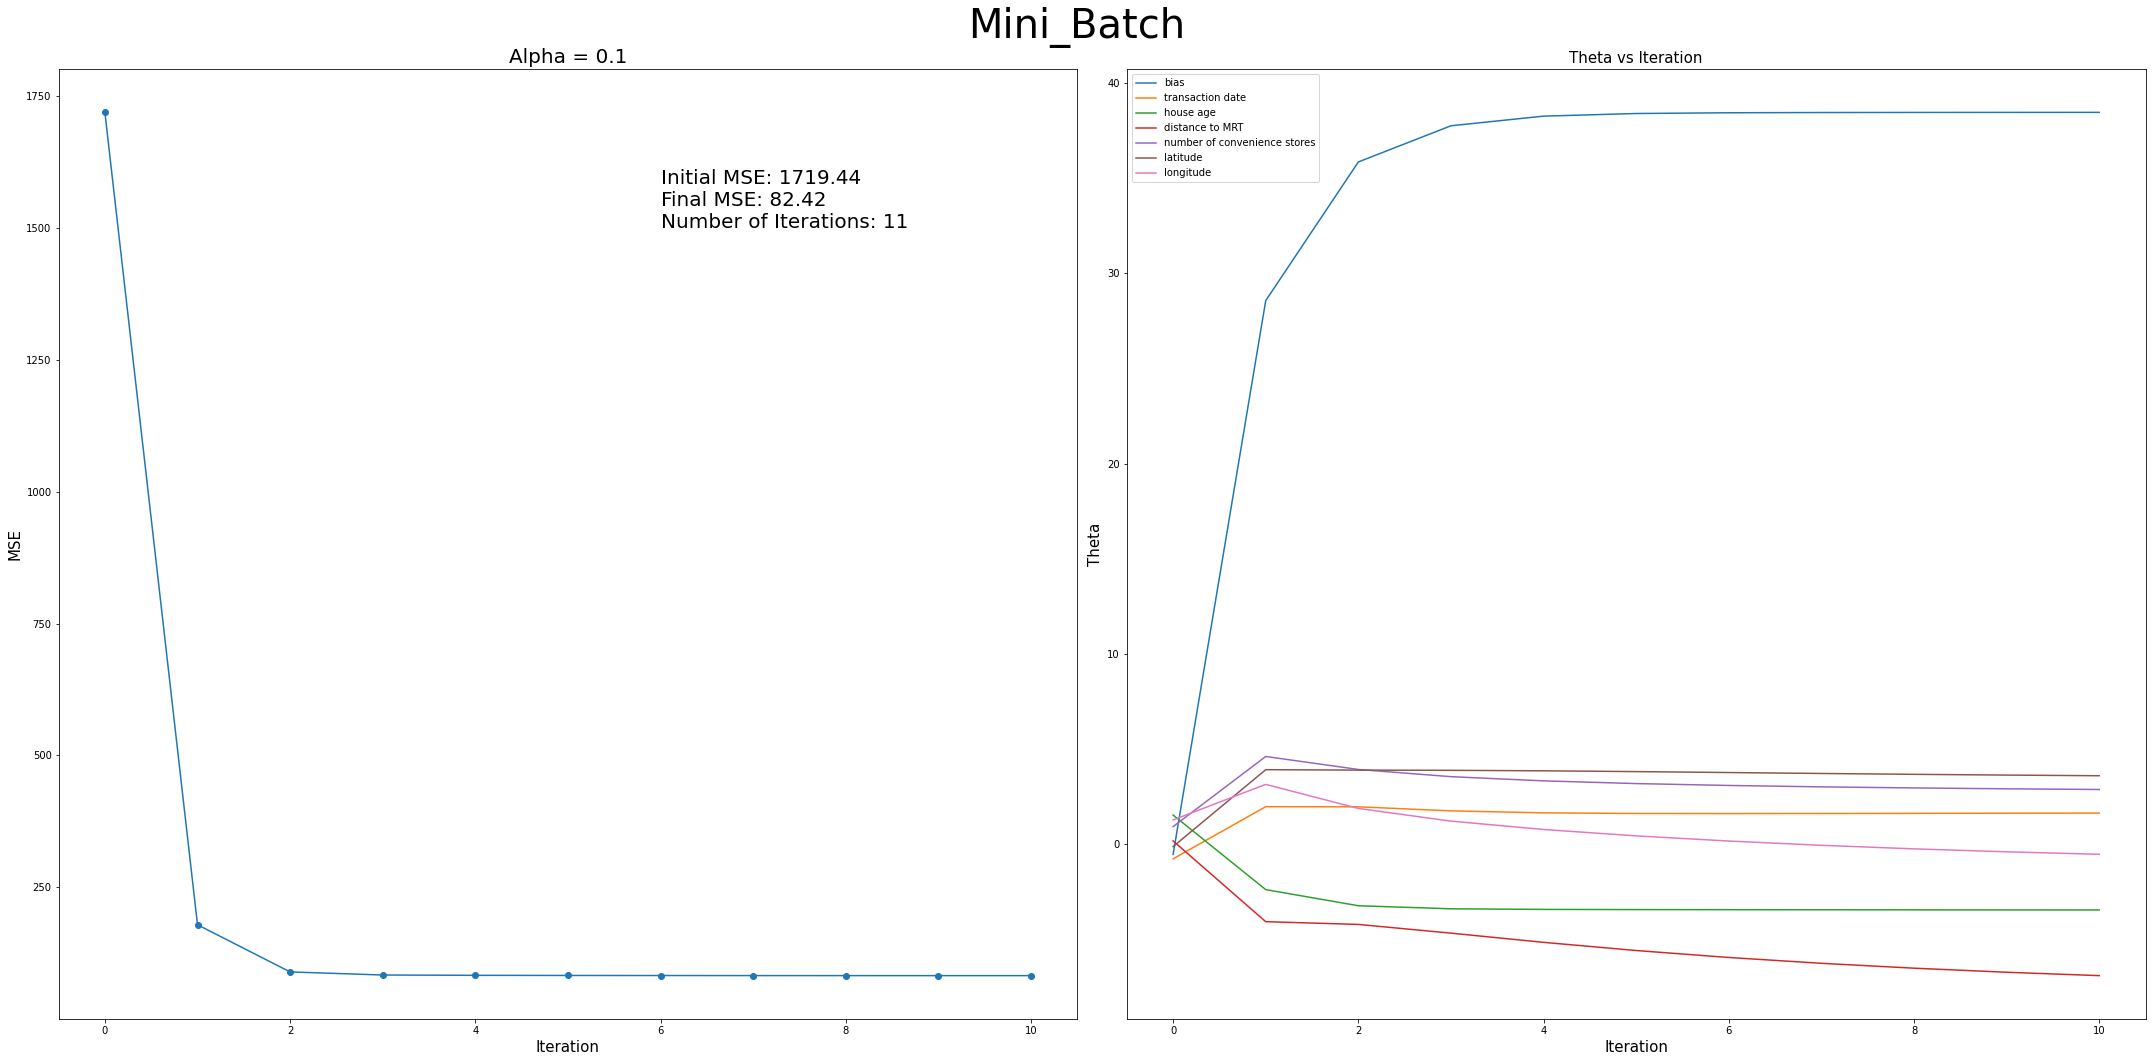

In [165]:
model = gradient_descent(alpha=0.1, algorithm = 'Mini_Batch')
model.train(X_train, y_train, batch_size = 50)

# Results
The weights of each feature can be seen in the 'Theta vs Iteration' graph. WE can see the features that have a postitive impact on house price are latitude, number of convenience stores, transaction date, and longitude. House age and distance to MRT have a negative impact on the price. The MSE of our model is about 82, which means each prediction has an average error of about $9. 

Gradient descent provides an expedient way to find a minimum within an error function. Because gradient descent calcualtes the slope to determine which direction to take a step, it can easily get 'stuck' at local minima. Calculation time and memory usage can also cause issues. The three variations of gradient descent provide solutions to either side of this problem. 